In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import category_encoders as ce

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score


LOCAL = '../data/tanzania/'
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Tree-Ensembles/master/data/tanzania/'
source = WEB

train = pd.merge(pd.read_csv(source + 'train_features.csv'), 
                 pd.read_csv(source + 'train_labels.csv'))
test = pd.read_csv(source + 'test_features.csv')
sample_submission = pd.read_csv(source + 'sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
43360,72938,0.0,2011-07-27,NaN,0,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,K,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
7263,65358,500.0,2011-03-23,Rc Church,2049,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175,True,GeoData Consultants Ltd,WUA,Tove Mtwango gravity Scheme,True,2008,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2486,469,25.0,2011-03-07,Donor,290,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300,True,GeoData Consultants Ltd,VWC,NaN,False,2010,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
313,1298,0.0,2011-07-31,Government Of Tanzania,0,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
52726,27001,0.0,2011-03-10,Water,0,Gove,35.389331,-6.399942,Chama,0,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,0,True,GeoData Consultants Ltd,VWC,Zeje,True,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional


In [4]:
#Use mode as a baseline model
y_train = train['status_group']
majority_class = y_train.mode()[0]
y_pred = [majority_class]*len(y_train)

accuracy_score(y_train,y_pred)

0.5430765993265994

In [5]:
# Check target distribution for train and val datasets

In [6]:
train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [7]:
val['status_group'].value_counts(normalize=True)

functional                 0.543098
non functional             0.384259
functional needs repair    0.072643
Name: status_group, dtype: float64

In [8]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    X = X.drop(columns=['recorded_by', 'id'])
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

        
        
        
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [9]:
#Dakota's Data-Cleaning
#Unusued
def MrClean(df):
    df_t= df
    df_t['gps_height'].replace(0.0, np.nan, inplace=True)
    df_t['population'].replace(0.0, np.nan, inplace=True)
    df_t['amount_tsh'].replace(0.0, np.nan, inplace=True)
    df_t['gps_height'].fillna(df_t.groupby(['region', 'district_code'])['gps_height'].transform('mean'), inplace=True)
    df_t['gps_height'].fillna(df_t.groupby(['region'])['gps_height'].transform('mean'), inplace=True)
    df_t['gps_height'].fillna(df_t['gps_height'].mean(), inplace=True)
    df_t['population'].fillna(df_t.groupby(['region', 'district_code'])['population'].transform('median'), inplace=True)
    df_t['population'].fillna(df_t.groupby(['region'])['population'].transform('median'), inplace=True)
    df_t['population'].fillna(df_t['population'].median(), inplace=True)
    df_t['amount_tsh'].fillna(df_t.groupby(['region', 'district_code'])['amount_tsh'].transform('median'), inplace=True)
    df_t['amount_tsh'].fillna(df_t.groupby(['region'])['amount_tsh'].transform('median'), inplace=True)
    df_t['amount_tsh'].fillna(df_t['amount_tsh'].median(), inplace=True)
    features=['amount_tsh', 'gps_height', 'population']
    #scaler = MinMaxScaler(feature_range=(0,20))
    #df_t[features] = scaler.fit_transform(df_t[features])
    df_t['longitude'].replace(0.0, np.nan, inplace=True)
    df_t['latitude'].replace(0.0, np.nan, inplace=True)
    df_t['construction_year'].replace(0.0, np.nan, inplace=True)
    df_t['latitude'].fillna(df_t.groupby(['region', 'district_code'])['latitude'].transform('mean'), inplace=True)
    df_t['longitude'].fillna(df_t.groupby(['region', 'district_code'])['longitude'].transform('mean'), inplace=True)
    df_t['longitude'].fillna(df_t.groupby(['region'])['longitude'].transform('mean'), inplace=True)
    df_t['construction_year'].fillna(df_t.groupby(['region', 'district_code'])['construction_year'].transform('median'), inplace=True)
    df_t['construction_year'].fillna(df_t.groupby(['region'])['construction_year'].transform('median'), inplace=True)
    df_t['construction_year'].fillna(df_t.groupby(['district_code'])['construction_year'].transform('median'), inplace=True)
    df_t['construction_year'].fillna(df_t['construction_year'].median(), inplace=True)
    #df_t['date_recorded'] = pd.to_datetime(df_t['date_recorded'])
    #df_t['years_service'] = df_t.date_recorded.dt.year - df_t.construction_year
   
    garbage=['wpt_name','num_private','subvillage','region_code','management_group',
         'extraction_type_group','extraction_type_class','scheme_name','payment',
        'quality_group','source_type','source_class','waterpoint_type_group',
        'ward','public_meeting','permit','construction_year']
        #recorded_by, quantity_group, date_recorded
    #df_t.drop(garbage,axis=1, inplace=True)
    df_t.waterpoint_type = df_t.waterpoint_type.str.lower()
    df_t.funder = df_t.funder.str.lower()
    df_t.basin = df_t.basin.str.lower()
    df_t.region = df_t.region.str.lower()
    df_t.source = df_t.source.str.lower()
    df_t.lga = df_t.lga.str.lower()
    df_t.management = df_t.management.str.lower()
    df_t.quantity = df_t.quantity.str.lower()
    df_t.water_quality = df_t.water_quality.str.lower()
    df_t.payment_type=df_t.payment_type.str.lower()
    df_t.extraction_type=df_t.extraction_type.str.lower()
    df_t["funder"].fillna("other", inplace=True)
    df_t["scheme_management"].fillna("other", inplace=True)
    df_t["installer"].fillna("other", inplace=True)
    return df_t


#train = MrClean(train)
#val = MrClean(val)
#test = MrClean(test)

In [10]:
train.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity', 'source',
       'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group', 'year_recorded',
       'month_recorded', 'day_recorded', 'years'],
      dtype='object')

In [11]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[(cardinality <= 50)].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
#features = numeric_features

In [12]:
cardinality.sort_values(ascending=False)

wpt_name                 30661
subvillage               17231
scheme_name               2563
ward                      2082
installer                 1929
funder                    1716
lga                        124
region                      21
extraction_type             18
extraction_type_group       13
scheme_management           12
management                  12
source                      10
basin                        9
water_quality                8
extraction_type_class        7
waterpoint_type              7
payment                      7
source_type                  7
payment_type                 7
waterpoint_type_group        6
quality_group                6
management_group             5
quantity                     5
source_class                 3
permit                       2
public_meeting               2
dtype: int64

In [13]:
len(features)

33

In [14]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

In [15]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    
    #SimpleImputer(strategy='median'), 
    SimpleImputer(strategy='mean'), 
    
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)


Validation Accuracy 0.8096801346801347


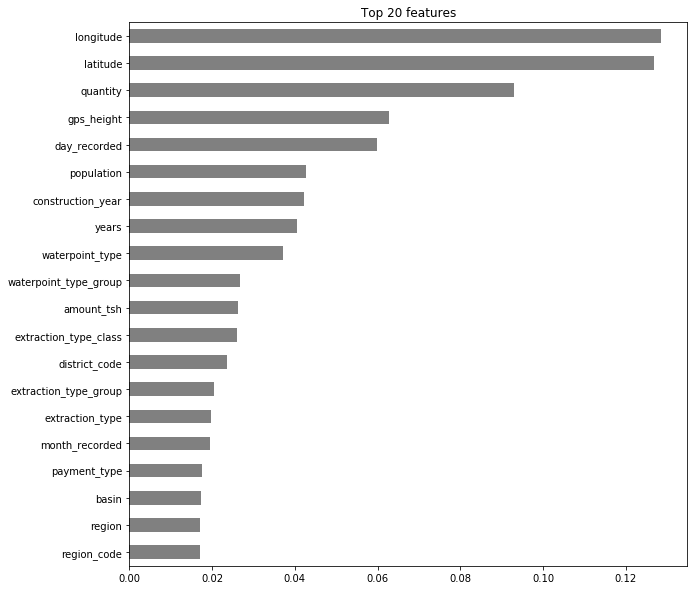

In [16]:
# Get feature importances
encoder = pipeline.named_steps['ordinalencoder']
tree = pipeline.named_steps['randomforestclassifier']

feature_names = encoder.transform(X_val).columns

importances = pd.Series(tree.feature_importances_, feature_names)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [17]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    
    #SimpleImputer(strategy='median'), 
    SimpleImputer(strategy='mean'), 

    
    XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx', 
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 14, colsample_bytree = .4, n_jobs = -1, random_state=42)
    #XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
    #              num_class = 3, maximize = False, eval_metric = 'merror',
    #              eta = .1, colsample_bytree = .4,
    #              max_depth = 14, n_jobs = -1, random_state=42)
                #  n_estimators=100, random_state=42, n_jobs = -1)
    #XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx', 
    #                  num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
    #                  max_depth = 14, colsample_bytree = .4)
)
# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8146464646464646


In [18]:
y_pred = pipeline.predict(X_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission2.csv', index=False)